## Realizations of neural network priors with different weight distributions in two dimension

In this Notebook, we show how to generate smooth samples using Gaussin neural network and Cauchy neural network. This can be generalized to more universal $\alpha$-stable distributions

In [1]:
# Import modules
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import normal
import matplotlib.pyplot as plt

### (1) Gaussian neural network realizations

In [2]:
def activation(z):
    return torch.tanh(z)

class GaussianNetwork(nn.Module):
    def __init__(self, D_in = 2, H1 = 200, H2 = 60, H3 = 160, D_out = 1, random_seed=0):
        super().__init__()
        # D_in, H1, H2, H3, D_out are the dimensions of input, hidden layers and
        # output, respectively. Random_seed can be set for reproduction.
        torch.manual_seed(random_seed)

        self.w1 = nn.Parameter(torch.randn((H1, D_in),dtype=torch.double))
        self.b1 = nn.Parameter(torch.randn((H1, 1),dtype=torch.double))
        self.w2 = nn.Parameter(torch.randn((H2, H1),dtype=torch.double))
        self.b2 = nn.Parameter(torch.randn((H2, 1),dtype=torch.double))
        self.w3 = nn.Parameter(torch.randn((H3, H2),dtype=torch.double))
        self.b3 = nn.Parameter(torch.randn((H3, 1),dtype=torch.double))
        self.w4 = nn.Parameter(torch.randn((D_out, H3),dtype=torch.double))

    def forward(self, X):
        hidden_1 = activation(self.w1.mm(X) + self.b1)
        hidden_2 = activation(self.w2.mm(hidden_1) + self.b2)
        hidden_3 = activation(self.w3.mm(hidden_2) + self.b3)
        y_pred = self.w4.mm(hidden_3)/np.sqrt(list(self.w4.shape)[-1])
        return y_pred

In [5]:
D_in = 2
H1 = 80
H2 = 80
H3 = 1000
D_out = 1

M = 300
(x0, xf) = (-1, 1)
(y0, yf) = (-1, 1)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)
X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))
XX = torch.tensor(np.concatenate((X.reshape(1, -1), Y.reshape(1, -1)), axis = 0), dtype = torch.double)

G_v = []

# Generate Samples
for i in range(20):
    net = GaussianNetwork(D_in = D_in, H1 = H1, H2 = H2, H3 = H3, D_out = D_out, random_seed=i+10)
    G_v.append(net(XX).detach().view(-1))

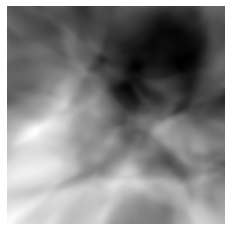

In [17]:
plt.figure()
# for i in range(4):
plt.imshow(G_v[0].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
plt.axis('off')
plt.show()

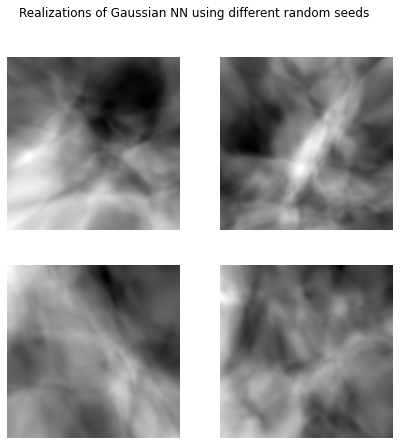

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
fig.suptitle('Realizations of Gaussian NN using different random seeds')
ax1.imshow(G_v[0].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax2.imshow(G_v[1].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax3.imshow(G_v[2].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax4.imshow(G_v[3].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

### (2) Cauchy neural network realizations

In [8]:
m_normal = normal.Normal(0, 1)
class Cauchy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        Forward equation
        """
        ctx.save_for_backward(input)
        return torch.tan(np.pi*m_normal.cdf(input)-np.pi/2) # input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward equation for auto-computing derivatives
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input = grad_input*((1 + torch.tan(np.pi*m_normal.cdf(input)-np.pi/2).pow(2)))*(np.pi*torch.exp(m_normal.log_prob(input)))
        return grad_input


cauchy = Cauchy.apply
class CauchyNetwork(nn.Module):
    def __init__(self, D_in = 2, H1 = 200, H2 = 60, H3 = 160, D_out = 1, random_seed=0):
        super().__init__()
        torch.manual_seed(random_seed)

        self.w1 = nn.Parameter(torch.randn((H1, D_in),dtype=torch.double))
        self.b1 = nn.Parameter(torch.randn((H1, 1),dtype=torch.double))
        self.w2 = nn.Parameter(torch.randn((H2, H1),dtype=torch.double))
        self.b2 = nn.Parameter(torch.randn((H2, 1),dtype=torch.double))
        self.w3 = nn.Parameter(torch.randn((H3, H2),dtype=torch.double))
        self.b3 = nn.Parameter(torch.randn((H3, 1),dtype=torch.double))
        self.w4 = nn.Parameter(torch.randn((D_out, H3),dtype=torch.double))

    def forward(self, X):
        hidden_1 = activation(cauchy(self.w1).mm(X) + cauchy(self.b1))
        hidden_2 = activation(cauchy(self.w2).mm(hidden_1) + cauchy(self.b2))
        hidden_3 = activation(cauchy(self.w3).mm(hidden_2) + cauchy(self.b3))
        y_pred = cauchy(self.w4).mm(hidden_3)/list(self.w4.shape)[-1]

#         hidden_1 = torch.tanh(cauchy(self.w1).mm(XX) + cauchy(self.b1))
#         hidden_2 = torch.tanh(cauchy(self.w2).mm(hidden_1) + cauchy(self.b2))
#         hidden_3 = torch.tanh(cauchy(self.w3).mm(hidden_2) + cauchy(self.b3))
#         y_pred = self.w4.mm(hidden_3)/np.sqrt(40)
        return y_pred

In [10]:
D_in = 2
H1 = 80
H2 = 80
H3 = 1000
D_out = 1

M = 300
(x0, xf) = (-1, 1)
(y0, yf) = (-1, 1)

hx = (xf - x0)/(M-1)
hy = (yf - y0)/(M-1)
X, Y = np.meshgrid(np.linspace(x0, xf, M), np.linspace(y0, yf, M))
XX = torch.tensor(np.concatenate((X.reshape(1, -1), Y.reshape(1, -1)), axis = 0), dtype = torch.double)

C_v = []

# Generate Samples
for i in range(20):
    net = CauchyNetwork(D_in = D_in, H1 = H1, H2 = H2, H3 = H3, D_out = D_out, random_seed=i+10)
    C_v.append(net(XX).detach().view(-1))

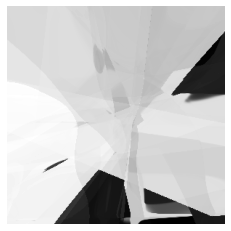

In [11]:
plt.figure()
# for i in range(4):
plt.imshow(C_v[0].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
plt.axis('off')
plt.show()

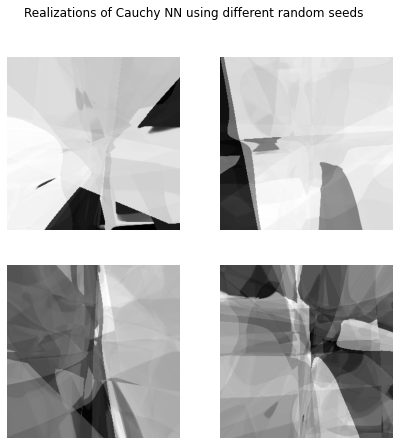

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
fig.suptitle('Realizations of Cauchy NN using different random seeds')
ax1.imshow(C_v[0].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax2.imshow(C_v[1].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax3.imshow(C_v[2].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])
ax4.imshow(C_v[3].reshape(M, M), cmap = 'gray', extent =[X.min(), X.max(), Y.min(), Y.max()])

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()